In [21]:
import numpy as np
import sorix
from sorix import tensor
from sorix.nn import Linear,CrossEntropyLoss,Conv2d,Relu,MaxPool2d,BatchNorm1D
from sorix.nn import NeuralNetwork
from sorix.optim import RMSprop,Adam
from sorix.datasets import train_test_split,Dataset,DataLoader
from sorix.metrics import classification_report, confusion_matrix
import pandas as pd
from datetime import datetime
import seaborn as sns

In [22]:
device = 'gpu' if sorix.cuda.is_available() else 'cpu'
device

✅ GPU basic operation passed
✅ GPU available: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA runtime version: 13000
CuPy version: 13.6.0


'gpu'

In [23]:
df = pd.read_csv('../data/digit-recognizer/train.csv')
df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


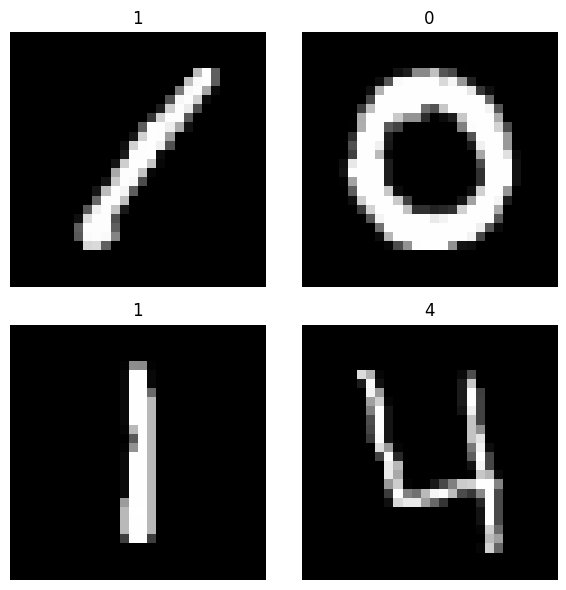

In [24]:
import matplotlib.pyplot as plt

# Crear un canvas de 4x4
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    # Obtener la i-ésima imagen (fila i, desde la columna 1 en adelante)
    img = df.iloc[i, 1:].values.reshape(28, 28)
    label = df.iloc[i, 0]  # etiqueta (columna 0)

    # Mostrar imagen en escala de grises
    ax.imshow(img, cmap="gray")
    ax.set_title(str(label))
    ax.axis("off")

plt.tight_layout()
plt.show()



In [25]:
df_train, df_test = train_test_split(df, test_size=0.2)

X_train = df_train.drop("label",axis=1).values
y_train = df_train[["label"]].values

X_test = df_test.drop("label",axis=1).values
y_test = df_test[["label"]].values

In [26]:
dataset_train = Dataset(X_train,y_train)
dataset_test = Dataset(X_test,y_test)

batch_size = 64
channels = 1
img_width = 28
img_height = 28

train_loader = DataLoader(dataset_train,batch_size=batch_size)
test_loader = DataLoader(dataset_test,batch_size=batch_size)

In [27]:
for X,Y in train_loader:

    X_tensor = tensor(X.reshape(batch_size,channels,img_width,img_height),device=device)
    Y_tensor = tensor(Y,device=device)
    print(X_tensor.shape)
    print(Y_tensor.shape)
    break


(64, 1, 28, 28)
(64, 1)


In [28]:
for X,Y in test_loader:

    X_tensor = tensor(X.reshape(batch_size,channels,img_width,img_height),device=device)
    Y_tensor = tensor(Y,device=device)
    print(X_tensor.shape)
    print(Y_tensor.shape)
    break

(64, 1, 28, 28)
(64, 1)


In [29]:
class Net(NeuralNetwork):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 8, kernel_size=(5, 5))
        self.pool1 = MaxPool2d(2, 2)
        self.conv2 = Conv2d(8, 8, kernel_size=(5, 5))
        self.pool2 = MaxPool2d(2, 2)
        self.fc1 = Linear(128, 32)   # 8*4*4 = 128
        self.bn1 = BatchNorm1D(32)
        self.fc2 = Linear(32, 10)
        self.relu = Relu()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.reshape(x.shape[0], -1)  # flatten
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

    
model = Net().to(device)
loss_fn = CrossEntropyLoss()

In [32]:
optimizer = RMSprop(model.parameters(),lr=0.001)

In [39]:
start = datetime.now()

epochs = 10

for epoch in range(epochs+1):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for X, Y in train_loader:
        X_tensor = tensor(X.reshape(len(Y),channels,img_width,img_height),device=device)
        Y_tensor = tensor(Y,device=device)

        # Forward
        logits = model(X_tensor)
        loss = loss_fn(logits, Y_tensor)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Acumular loss y accuracy
        total_train_loss += loss.data.get() * len(Y)  # ponderar por tamaño del batch
        preds = sorix.argmax(logits,axis=1,keepdims=True)
        correct_train += (preds == Y_tensor).sum().item()
        total_train += len(Y_tensor)

    avg_train_loss = total_train_loss / total_train
    avg_train_acc = correct_train / total_train

    # --- Validación/Test ---
    if epoch % 5 == 0:
        with sorix.no_grad():
            model.eval()
            total_test_loss = 0.0
            correct_test = 0
            total_test = 0

            for X, Y in test_loader:
                X_tensor = tensor(X.reshape(len(Y),channels,img_width,img_height),device=device)
                Y_tensor = tensor(Y,device=device)

                logits = model(X_tensor)
                loss = loss_fn(logits,Y_tensor)

                total_test_loss += loss.data.get() * len(Y_tensor)
                preds = sorix.argmax(logits,axis=1,keepdims=True)
                correct_test += (preds == Y_tensor).sum().item()
                total_test += len(Y_tensor)

            avg_test_loss = total_test_loss / total_test
            avg_test_acc = correct_test / total_test
            
            print(f"[{device}] [{epoch:3d}/{epochs:3d}] | Loss: {avg_test_loss:.4f} | Acc Train: {100*avg_train_acc:.2f}% | Acc Test: {100*avg_test_acc:.2f}%")

        if avg_test_acc > 0.98:
            break
end = datetime.now()

delta = end-start
tiempo = delta.total_seconds()
print(f"Tiempo:{tiempo} segundos = {tiempo/60:.2f} min ")

[gpu] [  0/ 10] | Loss: 0.0960 | Acc Train: 97.76% | Acc Test: 97.56%
[gpu] [  5/ 10] | Loss: 0.0961 | Acc Train: 97.81% | Acc Test: 97.58%
[gpu] [ 10/ 10] | Loss: 0.0963 | Acc Train: 97.83% | Acc Test: 97.57%
Tiempo:60.48856 segundos = 1.01 min 


In [40]:
all_preds = np.array([])
all_targets = np.array([])

with sorix.no_grad():
    model.eval()
    for x, y in test_loader:
        x = tensor(x.reshape(len(y),channels,img_width,img_height),device=device)
        y = tensor(y,device=device)
        # Predicciones
        logits = model(x)
        preds = sorix.argmax(logits,axis=1,keepdims=True).cpu()
        # Guardar predicciones y targets
        all_preds = np.append(all_preds,preds)
        all_targets = np.append(all_targets,y.cpu())

In [41]:
print(classification_report(all_targets,all_preds))

            precision   recall f1-score  support
0.0              0.98     0.99     0.99      798
1.0              0.98     0.99     0.98      920
2.0              0.97     0.97     0.97      797
3.0              0.97     0.97     0.97      858
4.0              0.98     0.98     0.98      813
5.0              0.97     0.97     0.97      772
6.0              0.99     0.98     0.98      849
7.0              0.97     0.99     0.98      929
8.0              0.97     0.96     0.96      810
9.0              0.97     0.96     0.97      854

accuracy                           0.98     8400
macro avg        0.98     0.98     0.98     8400
weighted avg     0.98     0.98     0.98     8400


<Axes: >

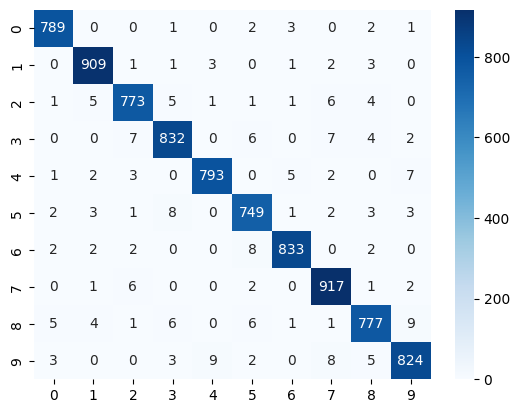

In [42]:
sns.heatmap(confusion_matrix(all_targets,all_preds), annot=True, cmap="Blues", fmt=".0f")